# Dataset Visualization

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import random
from seqgen.vocabulary import *
from seqgen.datasets.sequences import *
from seqgen.preprocess import *
from seqgen.seq_gen import add_noise_to_coordinates
from seqgen.symbol_replacement import replace_symbols

%load_ext autoreload
%autoreload 2

In [2]:
batch_size=4
max_length=25
img_width=800
img_height=200

vocab_in = Vocabulary(vocab_filename="seqgen/vocab_in.txt")
vocab_out = Vocabulary(vocab_filename="seqgen/vocab_out.txt")

dataset = SyntheticSequenceDataset(vocab_in, vocab_out, max_length, batch_size, continue_prob=0.95, device="cpu")

In [3]:
if os.path.exists("class_samples.pkl"):
    with open("class_samples.pkl", "rb") as f:
        class_samples = pickle.load(f)
else:
    basedir = "dataset-generation/archive/extracted_images"
    classes = os.listdir(basedir)
    class_samples = {}
    for c in classes:
        class_samples.update({c: []})
        for f in os.listdir(f"{basedir}/{c}"):
            if os.path.isfile(f"{basedir}/{c}/{f}"):
                class_samples[c].append(f)

    with open("class_samples.pkl", "wb") as f:
        pickle.dump(class_samples, f)

In [4]:
input_seqs, coordinates, target_seqs = dataset[0]

C:\Users\tilof\PycharmProjects\UdacityProjects\YoloImagePreparation\seqgen\datasets\sequences.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seqs = torch.tensor(features[:, :, 0]).to(torch.int64)
C:\Users\tilof\PycharmProjects\UdacityProjects\YoloImagePreparation\seqgen\datasets\sequences.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coordinates = torch.tensor(features[:, :, 1:])


In [5]:
coordinates[:, :, [0,2]] *= img_width
coordinates[:, :, [1,3]] *= img_height

In [6]:
def map_symbols_to_classes(symbol):
    mappings = {'a':'A', 'b':'B', 'c':'C', 'COMMA':',', 'd':'D', 'e':'E', 'f':'F', 'g':'G', 'h':'H', 'i':'I', 'j':'J', 'k':'K', 'l':'L', 'm':'M', 'n':'N', 'o':'O', 'p':'P', 'phi':'phi_lower', 'prime':',', 'q':'Q', 'r':'R', 's':'S', 't':'T', 'sum':'sigma_upper', 'U':'u', 'V':'v', 'W':'w', 'x':'X', 'Y':'y', 'Z':'z', '|': 'vert', '/':'vert'}
    if symbol in mappings.keys():
        return mappings[symbol]
    return symbol

def load_image(symbol, class_samples):
    n_samples = len(class_samples[symbol])
    idx = random.randint(0, n_samples-1)
    # Read image.
    img = cv2.imread(f'dataset-generation/archive/extracted_images/{symbol}/{class_samples[symbol][idx]}', cv2.IMREAD_GRAYSCALE)
    #img = cv2.erode(img, np.ones((5, 5), np.uint8), iterations=1)
    return img

def create_img_array_from_coordinates(coordinates, img_height, img_width):
    img_array = torch.zeros((img_height, img_width))
    for i in range(max_length):
        x0, y0, x1, y1 = coordinates[i].to(torch.int64)
        img_array[int(y0):int(y1), int(x0):int(x0)+1] = 1.0
        img_array[int(y0):int(y1), int(x1):int(x1)+1] = 1.0
        img_array[int(y0):int(y0)+1, int(x0):int(x1)] = 1.0
        img_array[int(y1):int(y1)+1, int(x0):int(x1)] = 1.0
    return img_array

def create_cv2img_array_from_coordinates(input_seqs, coordinates, img_height, img_width, vocab, smallest_index=3):
    img_array = np.ones((img_height, img_width))
    for i in range(max_length):
        if input_seqs[i] < smallest_index:
            continue
        symbol = vocab_in.idx2word[int(input_seqs[i])]
        img = load_image(map_symbols_to_classes(symbol.replace('\\', '')), class_samples) / 255
        x0, y0, x1, y1 = coordinates[i].to(torch.int64)
        w, h = int(x1 - x0), int(y1 - y0)
        if (w > 0 and h > 0):
            img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
            img = cv2.erode(img, np.ones((2, 2), np.uint8), iterations=3)
            img_array[int(y0):int(y0)+h, int(x0):int(x0)+w] = img
    return img_array

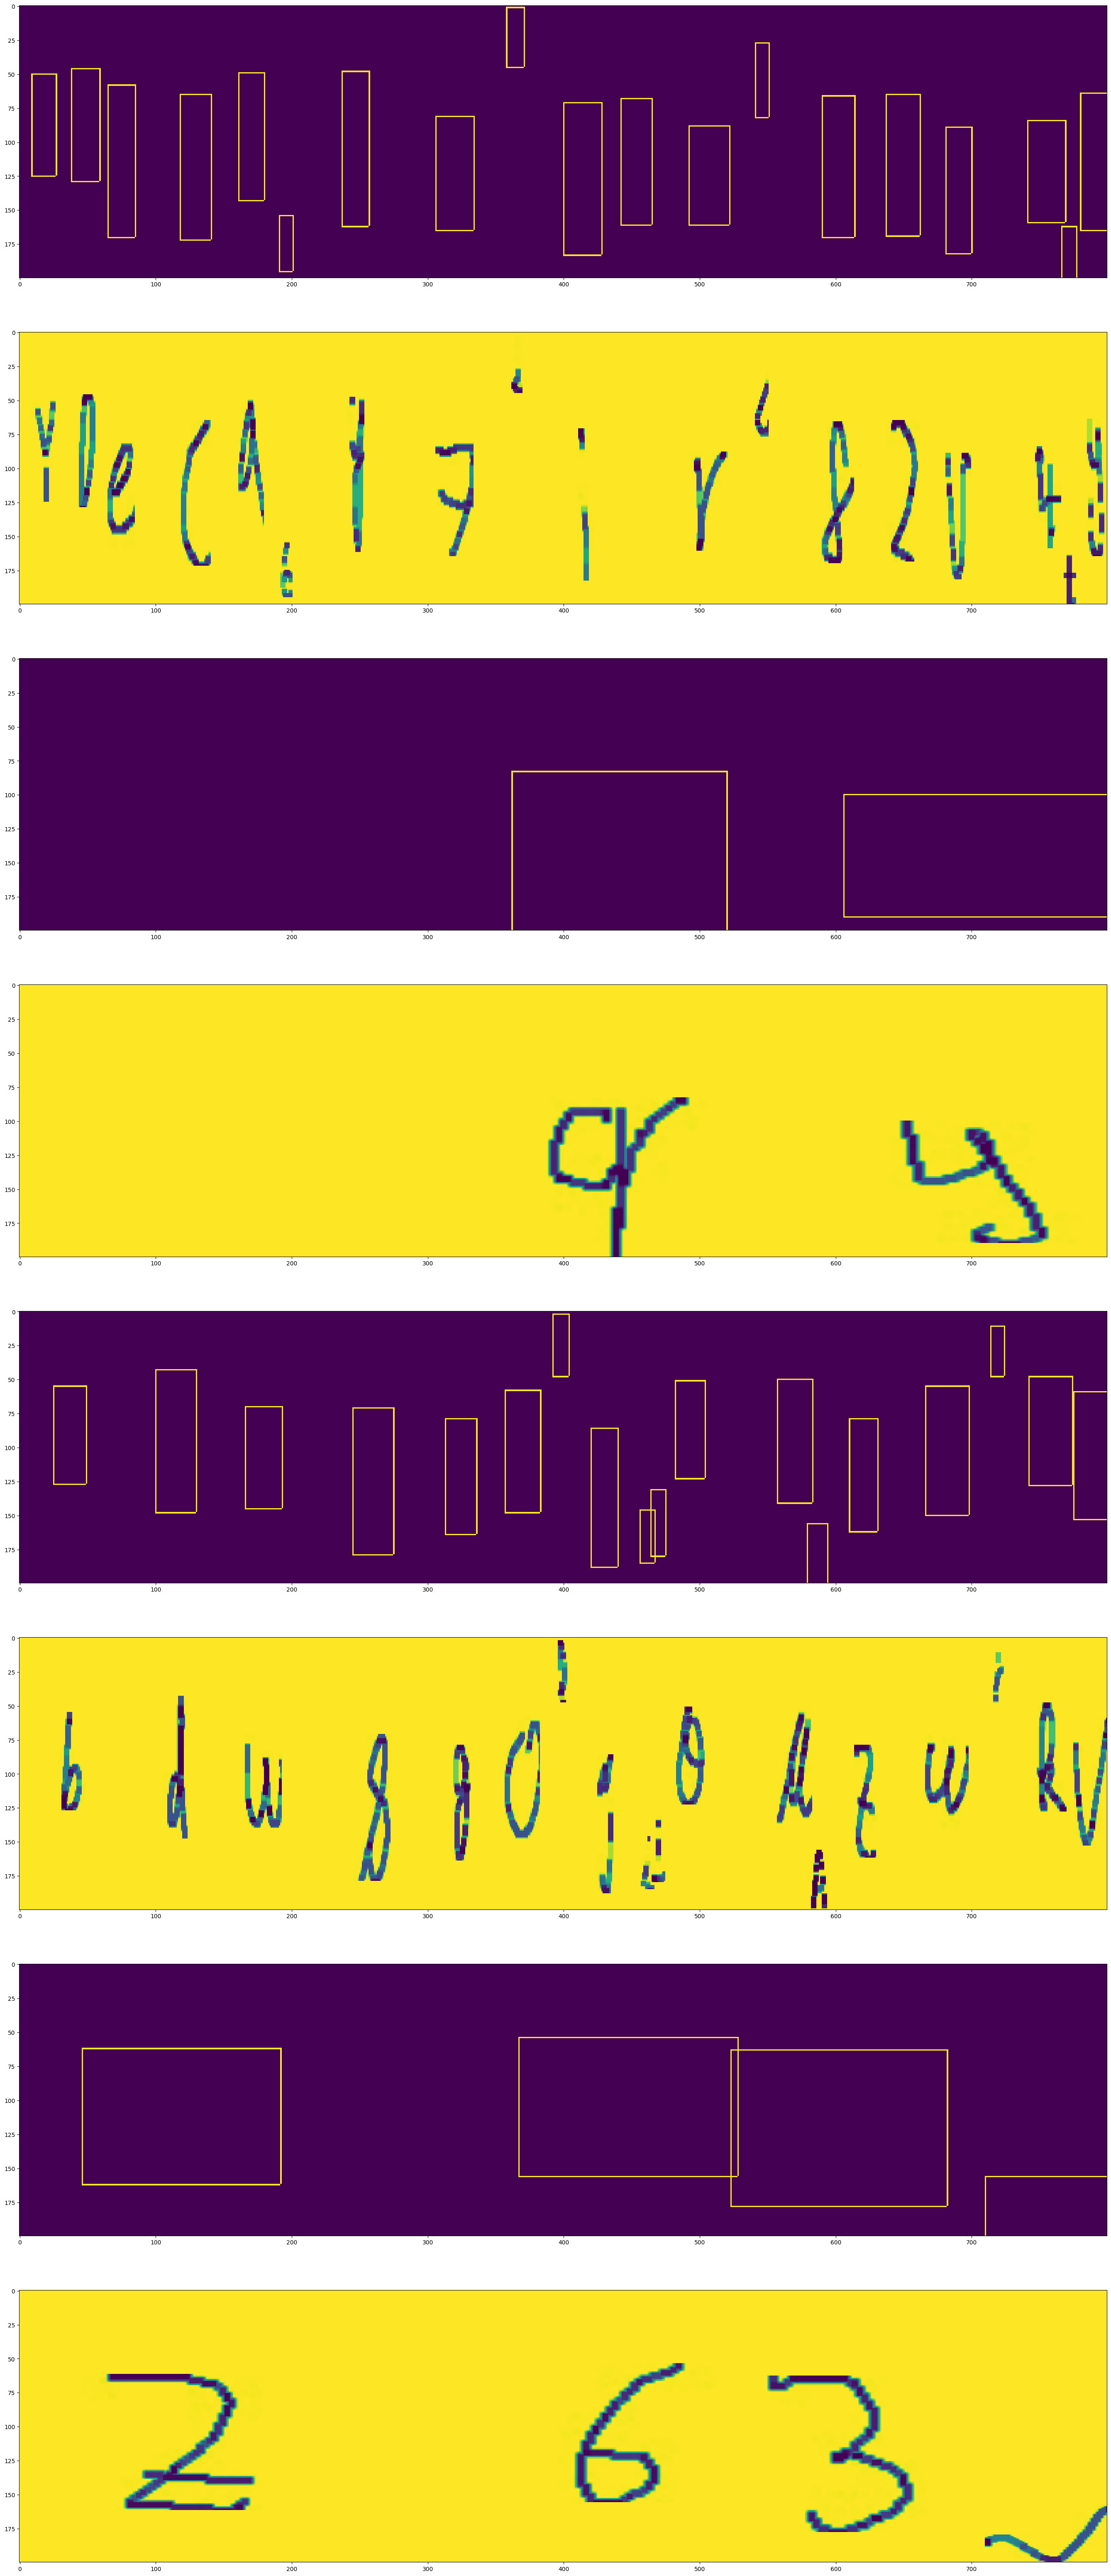

In [7]:
fig, ax = plt.subplots(batch_size*2, figsize=(50, 80))

for i in range(batch_size):
    ax[2*i].imshow(create_img_array_from_coordinates(coordinates[i], img_height, img_width))
    ax[2*i+1].imshow(create_cv2img_array_from_coordinates(input_seqs[i], coordinates[i], img_height, img_width, vocab_in))

In [8]:
from seqgen.datasets.realdata import RealSequencesDataset
dataset = RealSequencesDataset(filename="data/val/label.txt", vocab_in=vocab_in, vocab_out=vocab_out, max_length=50, batch_size=10)

input_seqs, coordinates, target_seqs = dataset.__getitem__(0)

KeyError: '.'

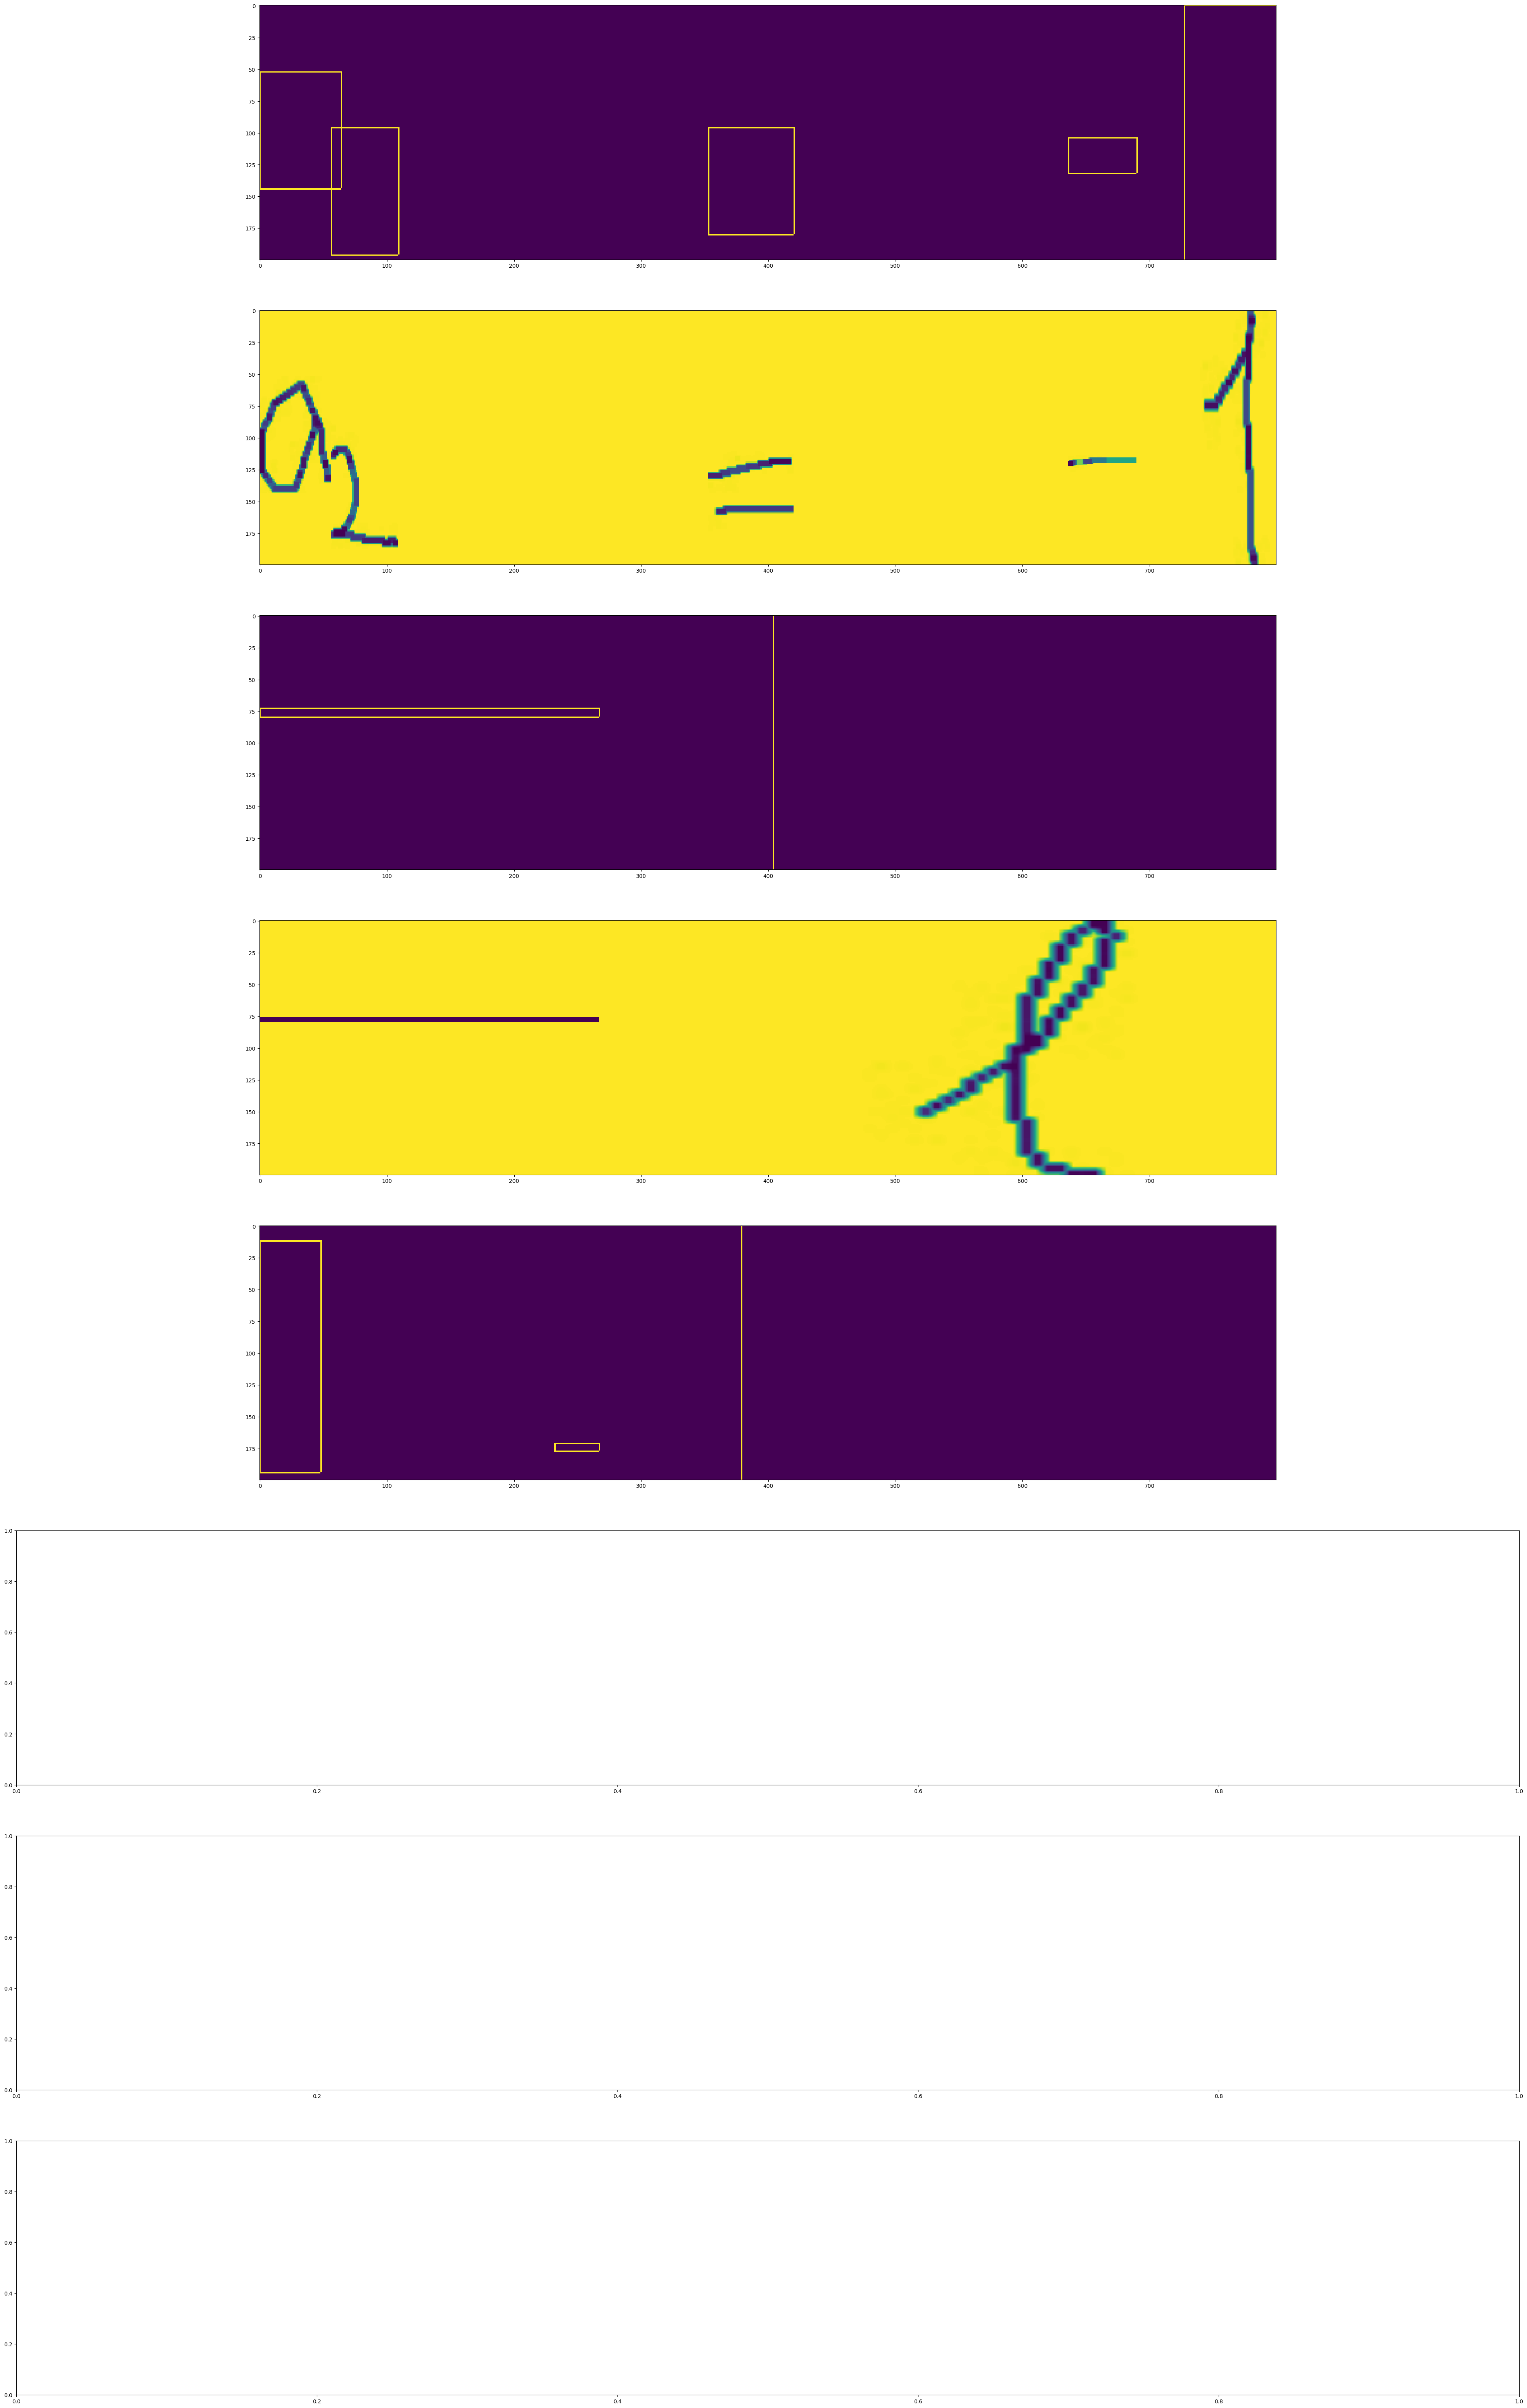

In [9]:
fig, ax = plt.subplots(2*batch_size, figsize=(50, 80))

for i in range(batch_size):
    coords = np.array(coordinates[i])
    coords = np.array(normalize_coordinates(np.array([coords]), contains_class=False)).squeeze()
    coords[:, [0,2]] *= img_width
    coords[:, [1,3]] *= img_height
    coords = torch.tensor(coords)
    ax[2*i].imshow(create_img_array_from_coordinates(coords, img_height, img_width).numpy())
    ax[2*i+1].imshow(create_cv2img_array_from_coordinates(input_seqs[i], coords, img_height, img_width, vocab_in))

In [ ]:
fig, ax = plt.subplots(2*batch_size, figsize=(50, 80))

for i in range(batch_size):
    coords = add_noise_to_coordinates(coordinates[i])
    coords = np.array(normalize_coordinates(np.array(coords), contains_class=False)).squeeze()
    coords[:, [0,2]] *= img_width
    coords[:, [1,3]] *= img_height
    coords = torch.tensor(coords)
    ax[2*i].imshow(create_img_array_from_coordinates(coords, img_height, img_width).numpy())
    ax[2*i+1].imshow(create_cv2img_array_from_coordinates(input_seqs[i], coords, img_height, img_width, vocab_in))

In [ ]:
fig, ax = plt.subplots(2*batch_size, figsize=(50, 80))

for i in range(batch_size):
    coords = add_noise_to_coordinates(coordinates[i])
    coords = np.array(normalize_coordinates(np.array(coords), contains_class=False)).squeeze()
    coords[:, [0,2]] *= img_width
    coords[:, [1,3]] *= img_height
    coords = torch.tensor(coords)
    in_seq, out_seq = replace_symbols(input_seqs[i], target_seqs[i], vocab_in, vocab_out)
    ax[2*i].imshow(create_img_array_from_coordinates(coords, img_height, img_width).numpy())
    ax[2*i+1].imshow(create_cv2img_array_from_coordinates(in_seq, coords, img_height, img_width, vocab_in))